# Multivariate analysis on traits

In [ ]:
# Multivariate analysis on traits

## I Data preparation

In [ ]:
# I Data preparation

### Packages loading

In [1]:
# Packages loading
library("mclust")
library("Rtsne")
library("ggplot2")
library("reshape2")
library("dplyr")
library("dendextend")
library("cluster")
library("fpc")

Package 'mclust' version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.


Attachement du package : ‘dplyr’


Les objets suivants sont masqués depuis ‘package:stats’:

    filter, lag


Les objets suivants sont masqués depuis ‘package:base’:

    intersect, setdiff, setequal, union



---------------------
Welcome to dendextend version 1.16.0
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use the r and dendextend tags: 
	 https://stackoverflow.com/questions/tagged/dendextend

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



Attachement du package : ‘dendextend’


L'objet suivant est masqué depuis ‘package:stats’:

    cutree

### Data loading

In [ ]:
# Data loading

In [2]:
df1<-read.csv("Path/to/your/file.tsv", sep ="\t") # omit sep ="\t" for .csv files

### Clustering continous data

In [ ]:
# Clustering continous data

In [34]:
mb1 = Mclust(as.numeric(df1$"Your_variable"))
summary(mb1, parameters = TRUE)

---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust E (univariate, equal variance) model with 2 components: 

 log-likelihood   n df       BIC       ICL
      -457.4768 522  4 -939.9843 -941.7598

Clustering table:
  1   2 
255 267 

Mixing probabilities:
        1         2 
0.4899639 0.5100361 

Means:
       1        2 
1.003189 2.210133 

Variances:
         1          2 
0.08642051 0.08642051 

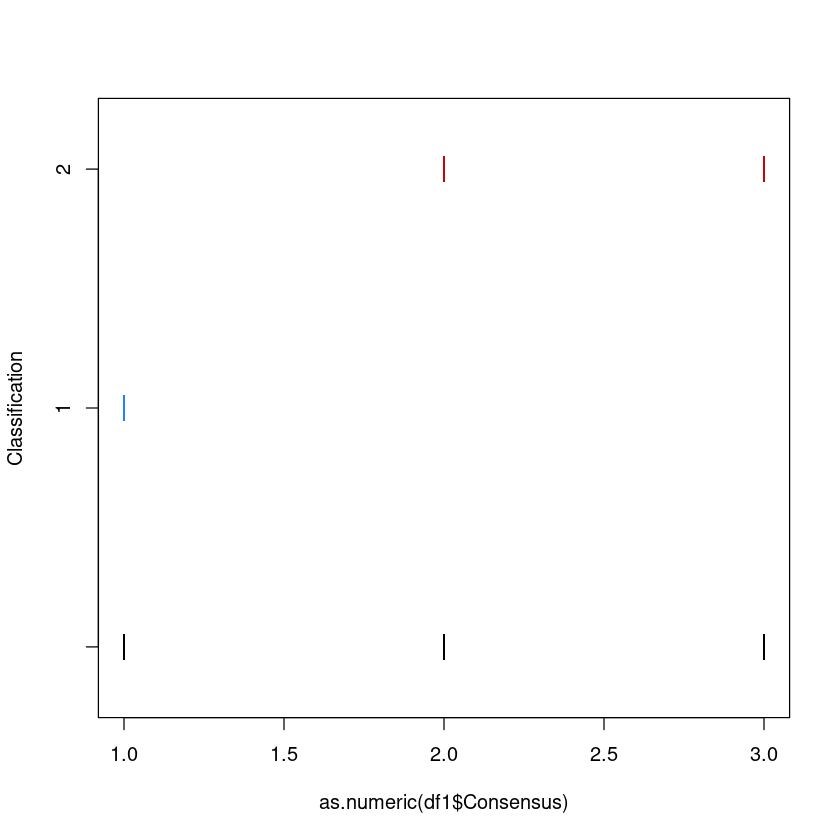

In [35]:
plot(mb1, what=c("classification")) # plot the discretization

In [6]:
df1$"Your_variable"<-mb1$classification

In [7]:
df1<-na.omit(df1)

## II Hierarchical clustering

In [ ]:
# Hierarchical clustering

In [8]:
df1<-(as.data.frame(unclass(df1),stringsAsFactors=TRUE))

In [9]:
df1$"Your_variable"<-as.factor(df1$"Your_variable")

In [10]:
rownames(df1)<-df1[,1]
df1<-df1[,-1]
df1.1<-df1

### Dissimilarity matrix creation

In [ ]:
# Dissimilarity matrix creation

In [12]:
gower.dist <- daisy(as.data.frame(df1, metric = c("gower")))

In [13]:
divisive.clust <- diana(as.matrix(gower.dist),diss = TRUE, keep.diss = TRUE)
aggl.clust.c <- hclust(gower.dist, method = "complete")
aggl.clust.m <- hclust(gower.dist, method = "average")
aggl.clust.w <- hclust(gower.dist, method = "ward.D2")

### 2-norm and  least square criterion

In [ ]:
# 2-norm and least square criterion

#### Complete

In [ ]:
# Complete

In [14]:
sigma <- var(gower.dist)+var(cophenetic(aggl.clust.c))
thres <- 2*sqrt(nrow(as.matrix(gower.dist))*sigma)
sign<-(thres > max(abs(eigen(gower.dist-cophenetic(aggl.clust.c))$values)))
col.c<-c("Complete", thres, sign, sum((eigen(gower.dist-cophenetic(aggl.clust.c))$values)**2))

#### UPGMA

In [ ]:
# UPGMA

In [15]:
sigma <- var(gower.dist)+var(cophenetic(aggl.clust.m))
thres <- 2*sqrt(nrow(as.matrix(gower.dist))*sigma)
sign<-(thres > max(abs(eigen(gower.dist-cophenetic(aggl.clust.m))$values)))
col.m<-c("UPGMA", thres, sign, sum((eigen(gower.dist-cophenetic(aggl.clust.m))$values)**2))

#### Ward

In [ ]:
# Ward

In [16]:
sigma <- var(gower.dist)+var(cophenetic(aggl.clust.w))
thres <- 2*sqrt(nrow(as.matrix(gower.dist))*sigma)
sign<-(thres > max(abs(eigen(gower.dist-cophenetic(aggl.clust.w))$values)))
col.w<-c("Ward", thres, sign, sum((eigen(gower.dist-cophenetic(aggl.clust.w))$values)**2))

#### Divisive

In [ ]:
# Divisive

In [17]:
sigma <- var(gower.dist)+var(cophenetic(divisive.clust))
thres <- 2*sqrt(nrow(as.matrix(gower.dist))*sigma)
sign<-(thres > max(abs(eigen(gower.dist-cophenetic(divisive.clust))$values)))
col.div<-c("Divisive", thres, sign, sum((eigen(gower.dist-cophenetic(divisive.clust))$values)**2))

### Comparaison of algorithm dataframe

In [ ]:
# Comparaison of algorithm dataframe

In [18]:
algo_sel <- rbind(col.c, col.m, col.w, col.div)
colnames(algo_sel)<-c("Name", "Threshold value", "Significance", "Least square")

In [19]:
algo_sel

,Name,Threshold value,Significance,Least square
col.c,Complete,16.0694616485558,FALSE,47008.2187500001
col.m,UPGMA,11.7575423691248,FALSE,5477.96845593552
col.w,Ward,112.830421076436,FALSE,6465299.83249241
col.div,Divisive,15.7036699310763,FALSE,46311.8124999997


In [ ]:
# Select the best algorithm, here : UPGMA

### Data repartition visualization

In [ ]:
# Following the method presented by Anastasia Reusova in her blogpost in Towardsdatascience

In [20]:
cstats.table <- function(dist, tree, k) {
clust.assess <- c("cluster.number","n","within.cluster.ss","average.within","average.between",
                  "wb.ratio","dunn2","avg.silwidth")
clust.size <- c("cluster.size")
stats.names <- c()
row.clust <- c()
output.stats <- matrix(ncol = k, nrow = length(clust.assess))
cluster.sizes <- matrix(ncol = k, nrow = k)
    for(i in c(1:k)){
  row.clust[i] <- paste("Cluster-", i, " size")
}
    for(i in c(2:k)){
  stats.names[i] <- paste("Test", i-1)
  
  for(j in seq_along(clust.assess)){
    output.stats[j, i] <- unlist(cluster.stats(d = dist, clustering = cutree(tree, k = i))[clust.assess])[j]
    
  }
  
  for(d in 1:k) {
    cluster.sizes[d, i] <- unlist(cluster.stats(d = dist, clustering = cutree(tree, k = i))[clust.size])[d]
    dim(cluster.sizes[d, i]) <- c(length(cluster.sizes[i]), 1)
    cluster.sizes[d, i]
    
  }
}
    output.stats.df <- data.frame(output.stats)
    cluster.sizes <- data.frame(cluster.sizes)
cluster.sizes[is.na(cluster.sizes)] <- 0
    rows.all <- c(clust.assess, row.clust)
output <- rbind(output.stats.df, cluster.sizes)[ ,-1]
colnames(output) <- stats.names[2:k]
rownames(output) <- rows.all
is.num <- sapply(output, is.numeric)
output[is.num] <- lapply(output[is.num], round, 2)
output
}

In [21]:
stats.df.agglm <-cstats.table(gower.dist, aggl.clust.m, 8) 
stats.df.agglm

,Test 1,Test 2,Test 3,Test 4,Test 5,Test 6,Test 7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cluster.number,2.00,3.00,4.00,5.00,6.00,7.00,8.00
n,522.00,522.00,522.00,522.00,522.00,522.00,522.00
within.cluster.ss,37.31,33.60,28.41,18.35,17.31,17.19,16.89
average.within,0.34,0.32,0.29,0.23,0.22,0.22,0.22
average.between,0.57,0.56,0.56,0.51,0.51,0.51,0.51
wb.ratio,0.59,0.57,0.52,0.45,0.43,0.43,0.43
dunn2,1.49,1.57,1.45,1.46,1.44,1.30,1.42
avg.silwidth,0.38,0.36,0.35,0.40,0.37,0.33,0.33
Cluster- 1 size,362.00,362.00,362.00,145.00,137.00,137.00,137.00


### Elbow visualization

In [ ]:
# Elbow visualization

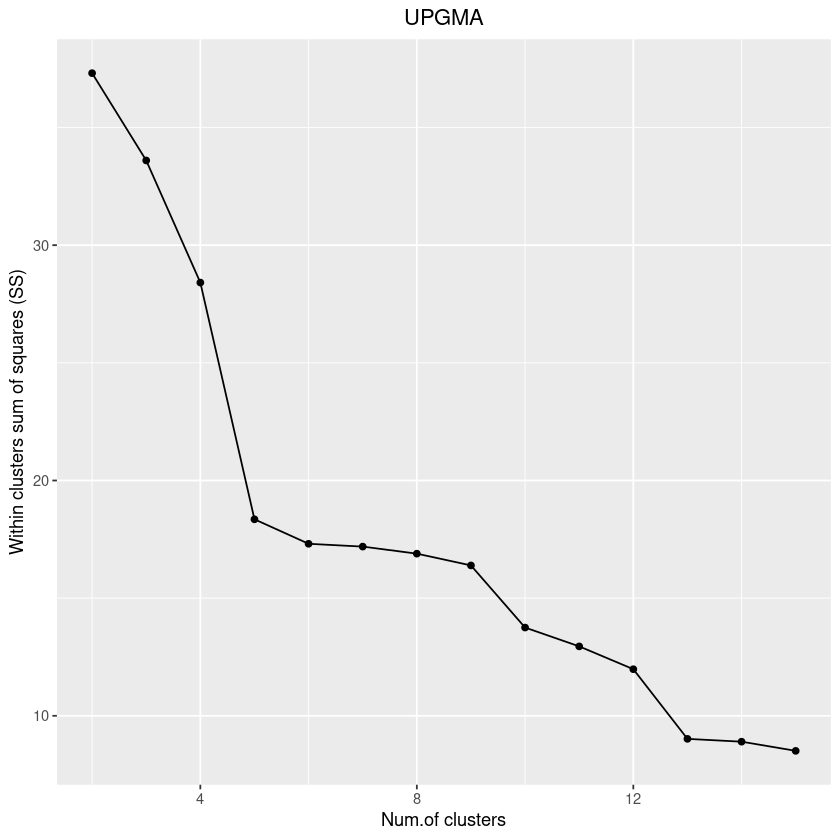

In [22]:
ggplot(data = data.frame(t(cstats.table(gower.dist, aggl.clust.m, 15))), 
  aes(x=cluster.number, y=within.cluster.ss)) + 
  geom_point()+
  geom_line()+
  ggtitle("UPGMA") +
  labs(x = "Num.of clusters", y = "Within clusters sum of squares (SS)") +
  theme(plot.title = element_text(hjust = 0.5))

### Silhouette visualization

In [ ]:
# Silhouette visualization

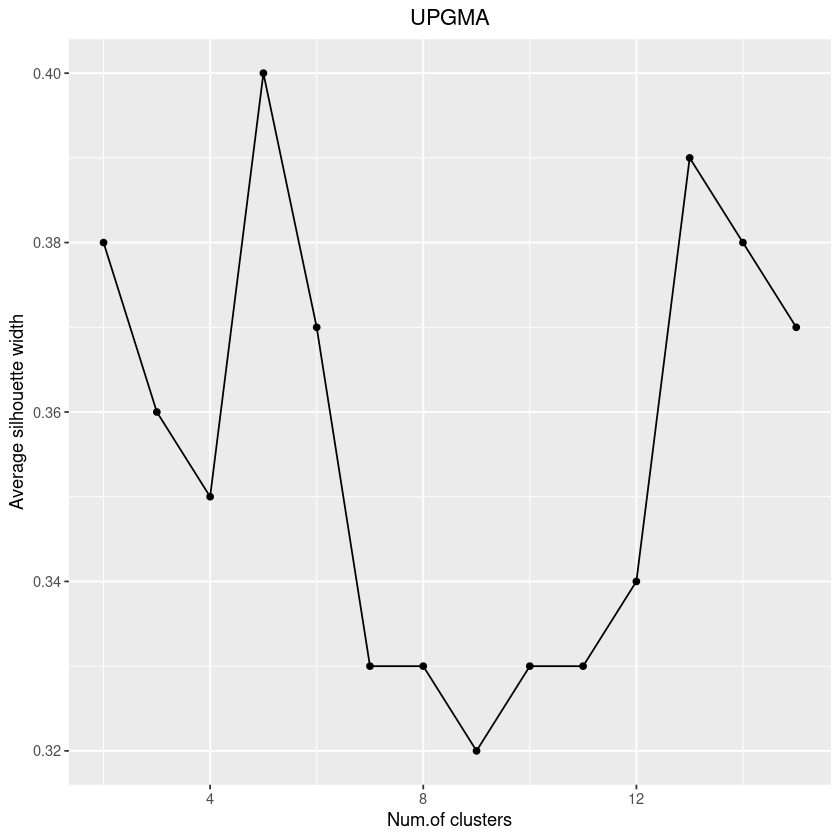

In [23]:
ggplot(data = data.frame(t(cstats.table(gower.dist, aggl.clust.m, 15))), 
  aes(x=cluster.number, y=avg.silwidth)) + 
  geom_point()+
  geom_line()+
  ggtitle("UPGMA") +
  labs(x = "Num.of clusters", y = "Average silhouette width") +
  theme(plot.title = element_text(hjust = 0.5))

#### Dendrogramme visualization

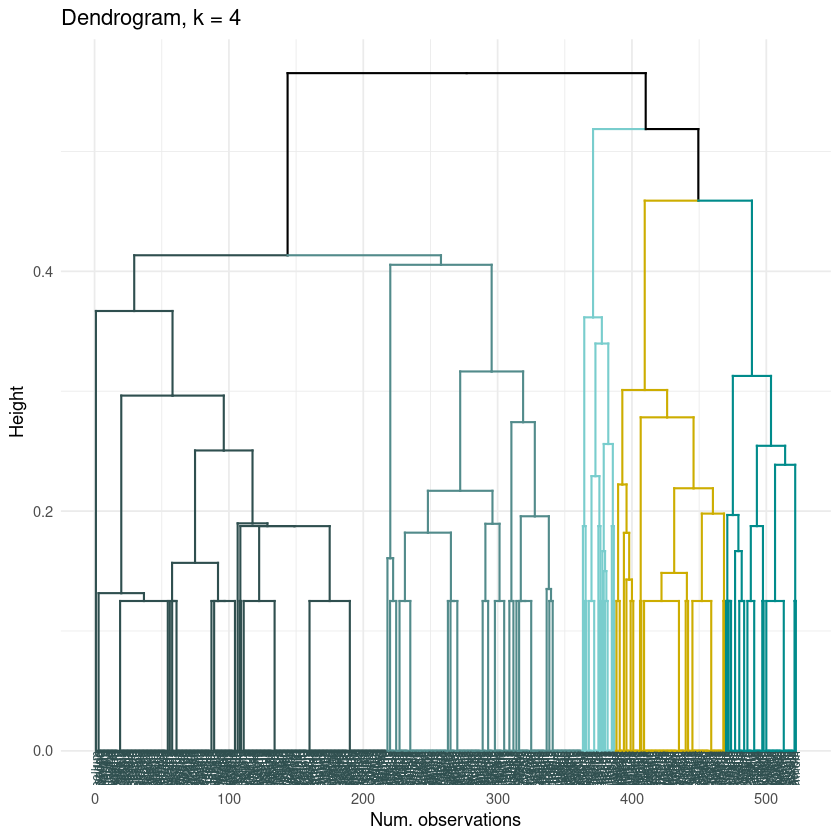

In [24]:
# Dendrogramme visualization
dendro <- as.dendrogram(aggl.clust.m)
dendro.col <- dendro %>%
  set("branches_k_color", k = 5, value =   c("darkslategray", "darkslategray4", "darkslategray3", "gold3", "darkcyan")) %>%
  set("branches_lwd", 0.6) %>%
  set("labels_colors", 
      value = c("darkslategray")) %>% 
  set("labels_cex", 0.5)
ggd1 <- as.ggdend(dendro.col)
ggplot(ggd1, theme = theme_minimal()) +
  labs(x = "Num. observations", y = "Height", title = "Dendrogram, k = 4")

### Traits & repartition for optimal group number

In [ ]:
# Traits & repartition for optimal group number

In [37]:
clust.num <- cutree(aggl.clust.m, k = 5)
df<-cbind(df1.1, clust.num)
df<-as.data.frame(unclass(df),stringsAsFactors=TRUE)
summary(df[df[,length(df[1,])]== 1,])
summary(df[df[,length(df[1,])]== 2,])
summary(df[df[,length(df[1,])]== 3,])
summary(df[df[,length(df[1,])]== 4,])
summary(df[df[,length(df[1,])]== 5,])

 Consensus Reproduction Lower.Slope.Deep Upper.Slope Shelf      Reef    
 1:60      O :52        No :129          No :69      No :  0   No :140  
 2:76      Oo: 2        Yes: 16          Yes:76      Yes:145   Yes:  5  
 3: 9      PV:14                                                        
           YV:77                                                        
                                                                        
                                                                        
 Coastal   Oceanic.coastal.pelagic   clust.num
 No :138   No :145                 Min.   :1  
 Yes:  7   Yes:  0                 1st Qu.:1  
                                   Median :1  
                                   Mean   :1  
                                   3rd Qu.:1  
                                   Max.   :1  

 Consensus Reproduction Lower.Slope.Deep Upper.Slope Shelf     Reef    Coastal 
 1: 0      O : 0        No :25           No :21      No : 9   No :17   No : 6  
 2: 1      Oo:13        Yes: 0           Yes: 4      Yes:16   Yes: 8   Yes:19  
 3:24      PV:10                                                               
           YV: 2                                                               
                                                                               
                                                                               
 Oceanic.coastal.pelagic   clust.num
 No : 0                  Min.   :2  
 Yes:25                  1st Qu.:2  
                         Median :2  
                         Mean   :2  
                         3rd Qu.:2  
                         Max.   :2  

 Consensus Reproduction Lower.Slope.Deep Upper.Slope Shelf      Reef    
 1:164     O : 93       No : 76          No : 54     No :217   No :216  
 2: 53     Oo:  4       Yes:141          Yes:163     Yes:  0   Yes:  1  
 3:  0     PV:  2                                                       
           YV:118                                                       
                                                                        
                                                                        
 Coastal   Oceanic.coastal.pelagic   clust.num
 No :217   No :217                 Min.   :3  
 Yes:  0   Yes:  0                 1st Qu.:3  
                                   Median :3  
                                   Mean   :3  
                                   3rd Qu.:3  
                                   Max.   :3  

 Consensus Reproduction Lower.Slope.Deep Upper.Slope Shelf     Reef    Coastal 
 1:27      O :39        No :53           No :51      No :46   No : 0   No :29  
 2:20      Oo: 1        Yes: 0           Yes: 2      Yes: 7   Yes:53   Yes:24  
 3: 6      PV: 1                                                               
           YV:12                                                               
                                                                               
                                                                               
 Oceanic.coastal.pelagic   clust.num
 No :53                  Min.   :4  
 Yes: 0                  1st Qu.:4  
                         Median :4  
                         Mean   :4  
                         3rd Qu.:4  
                         Max.   :4  

 Consensus Reproduction Lower.Slope.Deep Upper.Slope Shelf     Reef    Coastal 
 1: 4      O : 0        No :82           No :78      No :14   No :56   No : 0  
 2:61      Oo: 1        Yes: 0           Yes: 4      Yes:68   Yes:26   Yes:82  
 3:17      PV:62                                                               
           YV:19                                                               
                                                                               
                                                                               
 Oceanic.coastal.pelagic   clust.num
 No :81                  Min.   :5  
 Yes: 1                  1st Qu.:5  
                         Median :5  
                         Mean   :5  
                         3rd Qu.:5  
                         Max.   :5  

In [41]:
rownames(df)<-rownames(df1.1)

### Saving data

In [45]:
# Saving data
write.table(df, "Path/to/your/exit.file", sep ="\t")